In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
%matplotlib inline

In [17]:
########################################################################################################
# Pre-processing
########################################################################################################
# Define the path and get all json files
path = "../data/clean-dataset/"
all_files = glob.glob(os.path.join(path, "clean_*.json"))

# Read all files and concatenate into one DataFrame
dfs = []
for file in all_files :
    # Each JSON file contains one JSON per line
    df = pd.read_json(file, lines=True)
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)

# Convert date columns to datetime objects
data['date'] = pd.to_datetime(data['date'])
data['planned_arrival'] = pd.to_datetime(data['planned_arrival'])
data['real_arrival'] = pd.to_datetime(data['real_arrival'])

# Use IQR (Interquartile Range) Method to filter out statistical outliers.

def remove_outliers(df, col, multiplier=1.5) :
    # Remove outliers from a DataFrame column based on the IQR method.
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - multiplier * iqr
    upper_bound = q3 + multiplier * iqr
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]


# Use the function to remove outliers in arrival_delay_min
data_clean_iqr = remove_outliers(data, 'arrival_delay_min')

data_no_nan = data_clean_iqr.dropna(
    subset=['arrival_delay_min', 'temperature_2m', 'precipitation', 'snowfall', 'wind_speed_10m', 'cloudcover',
            'weathercode'])

# %%% Create new variables (categorical bins) for plotting

# Precipitation bins in mm (adjust as needed).
# Bin labels must be one fewer than the number of bin edges
bins = [0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14]
labels = ['0-0.02 mm', '0.02-0.04 mm', '0.04-0.06 mm', '0.06-0.08 mm', '0.08-0.10 mm', '0.10-0.12 mm', '0.12-0.14+ mm']

# Create categorical bins
data_no_nan = data_no_nan.copy()
data_no_nan.loc[:, 'precipitation_category'] = pd.cut(
    data_no_nan['precipitation'],
    bins=bins,
    labels=labels,
    include_lowest=True
)
# Snowfall bins in cm (adjust as needed).
# Bin labels must be one fewer than the number of bin edges
bins = [-0.01, 0, 0.1, 0.5, 1, 2, 5]
labels = ['0 cm', '0-0.1 cm', '0.1-0.5 cm', '0.5-1 cm', '1-2 cm', '2-5 cm']

# Create categorical bins
data_no_nan = data_no_nan.copy()
data_no_nan.loc[:, 'snowfall_category'] = pd.cut(
    data_no_nan['snowfall'],
    bins=bins,
    labels=labels,
    include_lowest=True
)
########################################################################################################
# Extracts the day of the week as a new column
data_no_nan['weekday'] = data_no_nan['date'].dt.day_name()

# Create new columns for month name and month number (to preserve order)
data_no_nan['month'] = data_no_nan['date'].dt.strftime('%B')
data_no_nan['month_num'] = data_no_nan['date'].dt.month
########################################################################################################
# Add original Weather Code description
"""
Weather condition is a numeric code. See table below for details.
WMO Weather interpretation codes (WW)
Code	    Description
0	        Clear sky
1,  2,  3	Mainly clear, partly cloudy, and overcast
45, 48	    Fog and depositing rime fog
51, 53, 55	Drizzle: Light, moderate, and dense intensity
56, 57	    Freezing Drizzle: Light and dense intensity
61, 63, 65	Rain: Slight, moderate and heavy intensity
66, 67	    Freezing Rain: Light and heavy intensity
71, 73, 75	Snow fall: Slight, moderate, and heavy intensity
77	        Snow grains
80, 81, 82	Rain showers: Slight, moderate, and violent
85, 86	    Snow showers slight and heavy
95 *	    Thunderstorm: Slight or moderate
96, 99 *	Thunderstorm with slight and heavy hail
(*) Thunderstorm forecast with hail is only available in Central Europe
"""
# Define the mapping for weather codes to descriptions
weather_mapping = {
    0 : "Clear sky",
    1 : "Mainly clear, partly cloudy, and overcast",
    2 : "Mainly clear, partly cloudy, and overcast",
    3 : "Mainly clear, partly cloudy, and overcast",
    45 : "Fog and depositing rime fog",
    48 : "Fog and depositing rime fog",
    51 : "Drizzle: Light, moderate, and dense intensity",
    53 : "Drizzle: Light, moderate, and dense intensity",
    55 : "Drizzle: Light, moderate, and dense intensity",
    56 : "Freezing Drizzle: Light and dense intensity",
    57 : "Freezing Drizzle: Light and dense intensity",
    61 : "Rain: Slight, moderate and heavy intensity",
    63 : "Rain: Slight, moderate and heavy intensity",
    65 : "Rain: Slight, moderate and heavy intensity",
    66 : "Freezing Rain: Light and heavy intensity",
    67 : "Freezing Rain: Light and heavy intensity",
    71 : "Snow fall: Slight, moderate, and heavy intensity",
    73 : "Snow fall: Slight, moderate, and heavy intensity",
    75 : "Snow fall: Slight, moderate, and heavy intensity",
    77 : "Snow grains",
    80 : "Rain showers: Slight, moderate, and violent",
    81 : "Rain showers: Slight, moderate, and violent",
    82 : "Rain showers: Slight, moderate, and violent",
    85 : "Snow showers slight and heavy",
    86 : "Snow showers slight and heavy",
    95 : "Thunderstorm: Slight or moderate",
    96 : "Thunderstorm with slight and heavy hail",
    99 : "Thunderstorm with slight and heavy hail"
}

# Map the weather codes to their descriptions
data_no_nan['orig_weather_description'] = data_no_nan['weathercode'].map(weather_mapping)

# Optionally, if there might be codes not covered by the mapping, assign 'Unknown'
data_no_nan['orig_weather_description'] = data_no_nan['orig_weather_description'].fillna('Unknown')


########################################################################################################
# Add simplified Weather Code description
def simplified_weather(code) :
    if code == 0 :
        return "Clear"
    elif code in [1, 2, 3] :
        return "Cloudy"
    elif code in [45, 48] :
        return "Fog"
    elif code in [51, 53, 55, 56, 57] :
        return "Drizzle"
    elif code in [61, 63, 65, 66, 67] :
        return "Rain"
    elif code in [71, 73, 75, 77, 85, 86] :
        return "Snow"
    elif code in [95, 96, 99] :
        return "Thunderstorm"
    else :
        return "Unknown"


data_no_nan['simp_weather_description'] = data_no_nan['weathercode'].apply(simplified_weather)

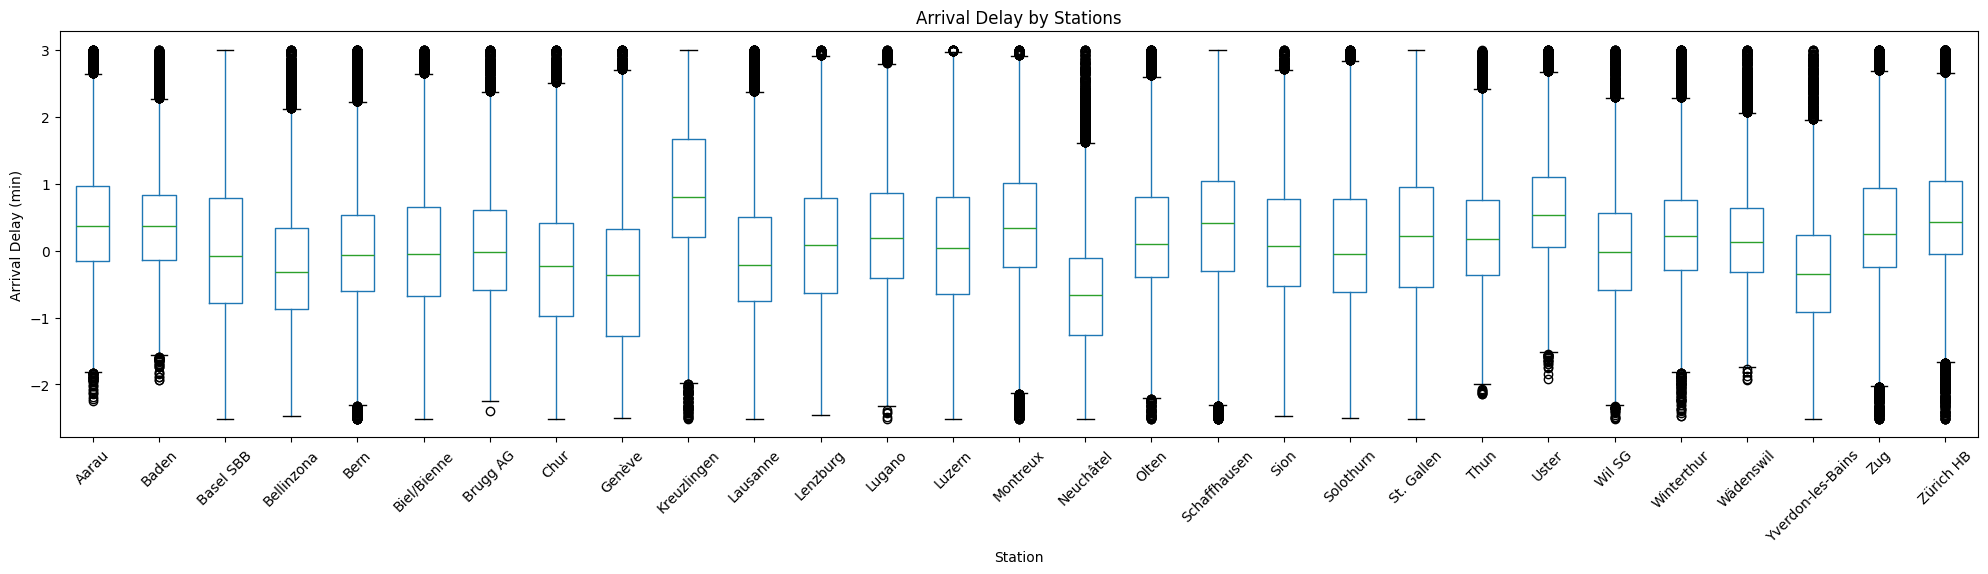

In [23]:
plt.rcParams['figure.figsize'] = (20, 6) # Changes the figure size for all plots
# Creates a box plot for arrival delays grouped by weekday
data_no_nan.boxplot(column='arrival_delay_min', by='station', grid=False)
plt.title("Arrival Delay by Stations")
plt.suptitle("")  # Remove default subtitle
plt.xlabel("Station")
plt.ylabel("Arrival Delay (min)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

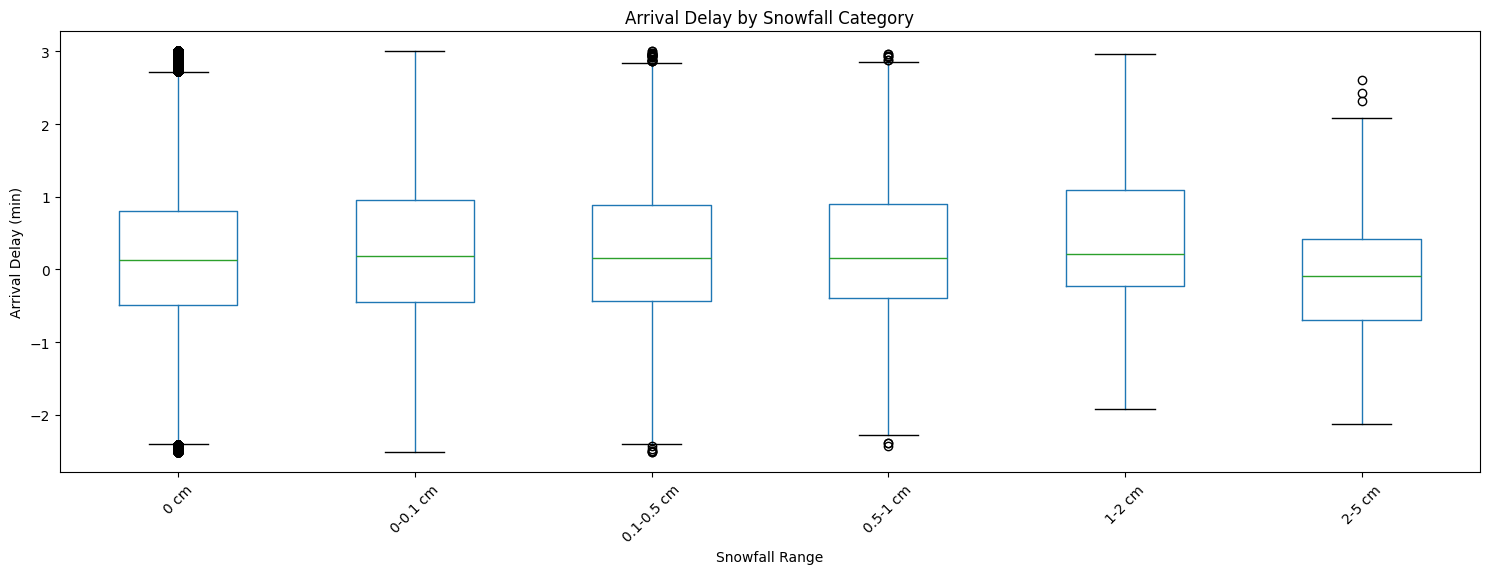

In [29]:
plt.rcParams['figure.figsize'] = (15, 6) # Changes the figure size for all plots
data_no_nan.boxplot(
    column='arrival_delay_min',
    by='snowfall_category',
    grid=False
)

plt.title("Arrival Delay by Snowfall Category")
plt.suptitle("")  # Remove the default subtitle
plt.xlabel("Snowfall Range")
plt.ylabel("Arrival Delay (min)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

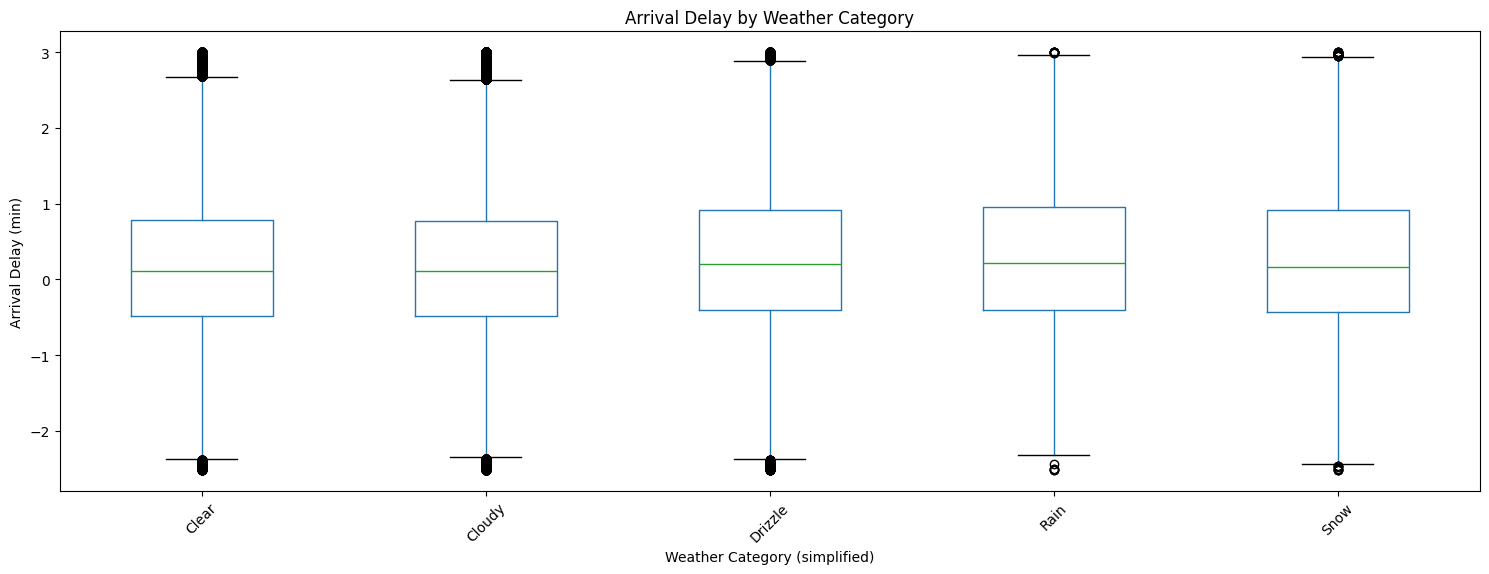

In [30]:
# Creates a box plot for arrival delays grouped by weekday
data_no_nan.boxplot(column='arrival_delay_min', by='simp_weather_description', grid=False)
plt.title("Arrival Delay by Weather Category")
plt.suptitle("")  # Remove default subtitle
plt.xlabel("Weather Category (simplified)")
plt.ylabel("Arrival Delay (min)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

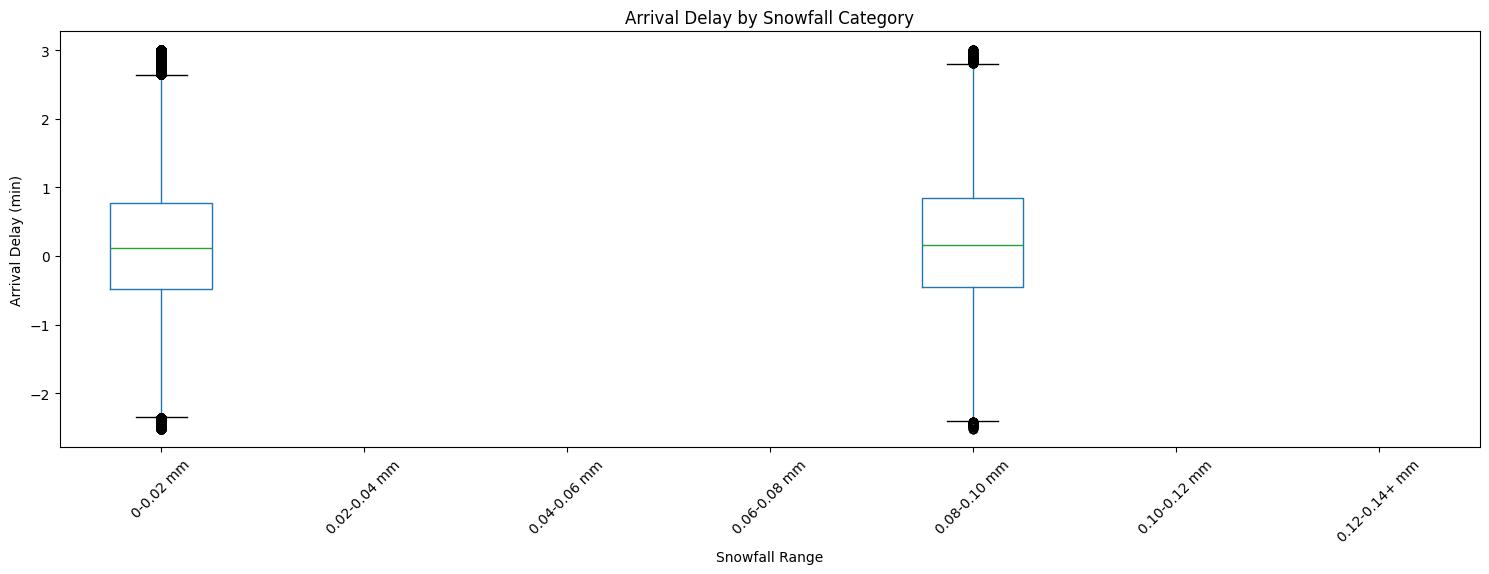

In [31]:
# Boxplot: Arrival Delay vs Precipitation
data_no_nan.boxplot(
    column='arrival_delay_min',
    by='precipitation_category',
    grid=False
)

plt.title("Arrival Delay by Snowfall Category")
plt.suptitle("")  # Remove the default subtitle
plt.xlabel("Snowfall Range")
plt.ylabel("Arrival Delay (min)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()